In [1]:
import pandas as pd

df = pd.read_csv('/run/media/anton/Seagate Portable Drive/PNC/phenotypes.txt', sep='\t', comment='#')
print(df)

       dbGaP_Subject_ID        SUBJID  INT_NUM INT_TYPE        Race Sex  \
0                791086  600001103037        1       MP          AA   M   
1                791086  600001103037        2       MI          AA   M   
2                791087  600001676724        1       AP          AA   F   
3                791088  600003245643        1      YPI          AA   M   
4                791090  600004963801        1       MP          EA   F   
...                 ...           ...      ...      ...         ...  ..   
14636            800198  609993878116        2       MI          EA   M   
14637            800199  609998081561        1       MP  EA,HI + OT   M   
14638            800199  609998081561        2       MI  EA,HI + OT   M   
14639            800200  609999144528        1       MP          EA   F   
14640            800200  609999144528        2       MI          EA   F   

       Med_birth_year Med_Rating  ADD011  ADD012  ...  SUB_OTC  SUB_PSY  \
0              1999.0   

/tmp/ipykernel_3785377/2654265512.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/run/media/anton/Seagate Portable Drive/PNC/phenotypes.txt', sep='\t', comment='#')


In [2]:
print(list(df.columns))

['dbGaP_Subject_ID', 'SUBJID', 'INT_NUM', 'INT_TYPE', 'Race', 'Sex', 'Med_birth_year', 'Med_Rating', 'ADD011', 'ADD012', 'ADD013', 'ADD014', 'ADD015', 'ADD016', 'ADD017', 'ADD018', 'ADD019', 'ADD020', 'ADD021', 'ADD022', 'ADD023', 'ADD024', 'ADD025', 'ADD026', 'ADD027', 'ADD028', 'ADD029', 'ADD030', 'ADD032', 'ADD033', 'ADD034', 'ADD034A', 'ADD035', 'ADD036', 'ADD050', 'AGR001', 'AGR002', 'AGR003', 'AGR004', 'AGR005', 'AGR006', 'AGR007', 'AGR008', 'AGR009', 'AGR010', 'AGR011', 'AGR012', 'AGR013', 'AGR014', 'AGR015', 'AGR016', 'AGR017', 'AGR018', 'AGR019', 'AGR020', 'AGR021', 'AGR022', 'AGR022A', 'AGR023', 'AGR024', 'AGR030', 'AGR035', 'CDD001', 'CDD001A', 'CDD002', 'CDD002A', 'CDD003', 'CDD004', 'CDD005', 'CDD006', 'CDD007', 'CDD008', 'CDD009', 'CDD010', 'CDD011', 'CDD013', 'CDD014', 'CDD015', 'CDD016', 'CDD017', 'CDD019', 'CDD020', 'CDD021', 'CDD022', 'CDD023', 'CDD024', 'CDD025', 'CDD026', 'CDD026A', 'CDD027', 'CDD028', 'DEP001', 'DEP002', 'DEP003', 'DEP004', 'DEP005', 'DEP006', 'DEP

In [2]:
import pickle

basedir = '/home/anton/Documents/Tulane/Research/PNC_Good/'
rest = pickle.load(open(f'{basedir}/PNC_SPM_rest.pkl', 'rb'))
nback = pickle.load(open(f'{basedir}/PNC_SPM_nback.pkl', 'rb'))
emoid = pickle.load(open(f'{basedir}/PNC_SPM_emoid.pkl', 'rb'))

print('Complete')

Complete


In [12]:
import numpy as np
from scipy import signal

def butter_bandpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = [cutoff[0] / nyq, cutoff[1] / nyq]
    b, a = signal.butter(order, normal_cutoff, btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, cutoff, fs, order=5):
    b, a = butter_bandpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

tr = 3

y = []
ps = []
a,b = np.triu_indices(264,1)

for i,ts in enumerate([rest, nback, emoid]):
    for sub in ts:
        val = list(df[df['SUBJID'] == int(sub)]['Sex'].dropna())
        if len(val) == 0:
            continue
        if not all(v == val[0] for v in val):
            print(f'Bad {sub} {val}')
            continue
#         if val[0] == 'EA':
#             val = 1
#         elif val[0] == 'AA':
#             val = 0
#         else:
#             continue
        val = int(val[0] == 'M')
        ts_filt = butter_bandpass_filter(ts[sub], [0.01, 0.15], 1/tr)
        p = np.corrcoef(ts_filt)
        if np.sum(np.isnan(p)) > 0:
            print(f'Bad ts {sub}')
            continue
        y.append(val)
        ps.append(p[a,b])
    print(f'Finished {i}')
    
y = np.stack(y)
ps = np.stack(ps)
    
print('Complete')
print(y[0:5])
print(ps.shape)

/usr/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/lib/python3.10/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Bad ts 601308609646
Bad ts 602818432787
Bad ts 603403163265
Bad ts 605300352682
Bad ts 605515760919
Bad ts 606447154458
Bad ts 607218468837
Finished 0
Bad ts 602818432787
Bad ts 603403163265
Finished 1
Finished 2
Complete
[1 0 0 1 0]
(4343, 34716)


In [33]:
from pathlib import Path
import re

basedir = '/home/anton/Documents/Tulane/Research/ImageNomer/data/anton/cohorts/BSNIP/'
demo = pickle.load(open(f'{basedir}/demographics.pkl', 'rb'))

y = []
ps = []

choice = dict(SZP=0, SADP=1, BPP=2)

for p in Path(f'{basedir}/fc').iterdir():
    m = re.match('^([^_]+).*.npy$', p.name)
    if not m:
        continue
    sub = m.group(1)
    if sub not in demo['DXGROUP_2']:
        continue
    diag = demo['DXGROUP_2'][sub]
    if diag not in choice:
        continue
    p = np.load(str(p))
    y.append(choice[diag])
    ps.append(p)
    
y = np.stack(y)
ps = np.stack(ps)
    
print('Complete')
print(y[0:5])
print(ps.shape)

Complete
[2 1 1 1 1]
(509, 34716)


In [28]:
df[df['SUBJID'] == 602818432787]['age_at_cnb']

4177    16.0
4178     NaN
Name: age_at_cnb, dtype: float64

In [20]:
from sklearn.cluster import KMeans

nc = 2
nums = []

for i in range(20):
    km = KMeans(n_clusters=nc, n_init='auto').fit(ps[y == 1])
    n = [np.sum(km.labels_ == lab) for lab in range(nc)]
    n = np.sort(n)
    print(n)
    nums.append(n)
    
nums = np.stack(nums)
print(nums)

[ 910 1126]
[ 914 1122]
[ 910 1126]
[ 910 1126]
[ 910 1126]
[ 910 1126]
[ 910 1126]
[ 914 1122]
[ 914 1122]
[ 914 1122]
[ 914 1122]
[ 914 1122]
[ 910 1126]
[ 910 1126]
[ 910 1126]
[ 914 1122]
[ 910 1126]
[ 914 1122]
[ 910 1126]
[ 910 1126]
[[ 910 1126]
 [ 914 1122]
 [ 910 1126]
 [ 910 1126]
 [ 910 1126]
 [ 910 1126]
 [ 910 1126]
 [ 914 1122]
 [ 914 1122]
 [ 914 1122]
 [ 914 1122]
 [ 914 1122]
 [ 910 1126]
 [ 910 1126]
 [ 910 1126]
 [ 914 1122]
 [ 910 1126]
 [ 914 1122]
 [ 910 1126]
 [ 910 1126]]


In [38]:
sz2 = '''[[ 69 130]
 [ 61 138]
 [ 61 138]
 [ 69 130]
 [ 69 130]
 [ 61 138]
 [ 62 137]
 [ 64 135]
 [ 64 135]
 [ 69 130]
 [ 69 130]
 [ 61 138]
 [ 61 138]
 [ 69 130]
 [ 69 130]
 [ 69 130]
 [ 69 130]
 [ 63 136]
 [ 68 131]
 [ 69 130]]'''

sz3 = '''[[ 31  81  87]
 [ 31  81  87]
 [ 21  68 110]
 [ 14  62 123]
 [ 34  78  87]
 [ 44  74  81]
 [  2  69 128]
 [ 30  60 109]
 [ 31  62 106]
 [ 34  74  91]
 [ 29  61 109]
 [ 28  70 101]
 [ 49  69  81]
 [  3  59 137]
 [ 44  75  80]
 [ 34  75  90]
 [ 34  71  94]
 [ 29  61 109]
 [  7  68 124]
 [  1  69 129]]'''

sz4 = '''[[  1  53  57  88]
 [ 21  45  64  69]
 [  1  51  58  89]
 [  2   3  61 133]
 [  2  26  66 105]
 [ 33  42  43  81]
 [  2  34  54 109]
 [  4  28  58 109]
 [ 13  42  63  81]
 [  5  41  58  95]
 [  1  21  64 113]
 [ 17  36  71  75]
 [ 16  44  63  76]
 [ 24  48  58  69]
 [  3  15  69 112]
 [  4  34  58 103]
 [  2  16  58 123]
 [  1  49  74  75]
 [  3  33  59 104]
 [ 12  32  75  80]]'''

sz5 = '''  [[ 13  33  35  44  74]
 [  1   2  27  61 108]
 [ 17  19  43  44  76]
 [  2  17  24  62  94]
 [ 14  14  39  56  76]
 [  7  24  42  51  75]
 [ 14  29  32  55  69]
 [  1  26  44  48  80]
 [  1  17  34  62  85]
 [  3   3  13  54 126]
 [  2   3  15  65 114]
 [ 13  28  40  48  70]
 [  1  22  42  62  72]
 [  2   3  48  71  75]
 [ 19  21  40  42  77]
 [  1  29  36  51  82]
 [  1  16  43  61  78]
 [  5   5  50  69  70]
 [  2   3  42  70  82]
 [  1  29  34  55  80]]'''

sad2 = '''[[ 43  97]
 [ 54  86]
 [ 35 105]
 [ 56  84]
 [ 50  90]
 [ 35 105]
 [ 56  84]
 [ 41  99]
 [ 50  90]
 [ 43  97]
 [ 35 105]
 [ 35 105]
 [ 42  98]
 [ 43  97]
 [ 55  85]
 [ 52  88]
 [ 52  88]
 [ 55  85]
 [ 35 105]
 [ 51  89]]'''

sad3 = '''[[ 29  51  60]
 [ 17  42  81]
 [ 27  41  72]
 [ 19  52  69]
 [ 33  49  58]
 [ 30  37  73]
 [ 30  37  73]
 [ 24  52  64]
 [ 20  46  74]
 [  3  53  84]
 [  1  45  94]
 [ 27  40  73]
 [ 33  45  62]
 [ 14  55  71]
 [ 29  43  68]
 [ 30  47  63]
 [  1  35 104]
 [ 33  45  62]
 [ 29  46  65]
 [  1  51  88]]'''

sad4 = '''[[ 1 16 42 81]
 [10 30 41 59]
 [ 2 28 41 69]
 [ 1 26 42 71]
 [ 3 31 46 60]
 [ 1 29 38 72]
 [11 31 47 51]
 [ 7 28 48 57]
 [ 1 29 54 56]
 [ 1 28 41 70]
 [ 1 30 46 63]
 [ 1 21 50 68]
 [17 22 43 58]
 [11 30 36 63]
 [ 4 28 38 70]
 [12 17 40 71]
 [25 25 30 60]
 [ 1 31 35 73]
 [24 29 32 55]
 [ 4  7 46 83]]'''

sad5 = ''' [[ 1  7 32 42 58]
 [18 29 30 30 33]
 [ 7 18 23 39 53]
 [ 1 28 29 36 46]
 [ 4  8 21 52 55]
 [ 1  3 26 38 72]
 [ 1 17 30 31 61]
 [ 1  6 19 51 63]
 [ 5 16 28 45 46]
 [ 5 18 29 41 47]
 [11 19 31 31 48]
 [ 4 21 28 30 57]
 [ 1 17 22 33 67]
 [ 1  2  8 54 75]
 [ 6 19 32 36 47]
 [ 6  8 17 41 68]
 [ 1  8 18 47 66]
 [ 2  4 16 41 77]
 [ 1  2 29 36 72]
 [ 1  2 29 38 70]]'''

bp2 = '''[[ 75  95]
 [ 77  93]
 [ 77  93]
 [ 77  93]
 [ 63 107]
 [ 77  93]
 [ 72  98]
 [ 77  93]
 [ 77  93]
 [ 60 110]
 [ 60 110]
 [ 61 109]
 [ 60 110]
 [ 10 160]
 [ 67 103]
 [ 77  93]
 [ 71  99]
 [ 61 109]
 [ 60 110]
 [ 6 164]'''

bp3 = '''[[ 33  55  82]
 [  4  60 106]
 [  3  78  89]
 [ 17  71  82]
 [ 24  68  78]
 [  1  60 109]
 [ 18  69  83]
 [ 29  52  89]
 [ 10  79  81]
 [ 36  51  83]
 [ 46  55  69]
 [ 24  69  77]
 [  5  59 106]
 [ 41  63  66]
 [ 28  57  85]
 [ 40  57  73]
 [ 39  58  73]
 [  6  59 105]
 [  2  65 103]
 [  1  75  94]]'''

bp4 = '''[[ 31  40  42  57]
 [  3   4  63 100]
 [ 26  37  49  58]
 [  2  22  41 105]
 [  4  33  57  76]
 [ 16  37  37  80]
 [  3  38  64  65]
 [  2  52  56  60]
 [  4  45  60  61]
 [ 17  38  48  67]
 [ 17  29  61  63]
 [ 26  38  39  67]
 [  2  13  62  93]
 [ 27  37  49  57]
 [ 13  23  52  82]
 [ 13  46  48  63]
 [ 19  25  60  66]
 [ 22  43  52  53]
 [ 15  29  52  74]
 [ 16  33  55  66]]'''

bp5 = ''' [[ 1  3 21 58 87]
 [ 2 14 24 43 87]
 [ 2 22 35 52 59]
 [12 22 33 44 59]
 [ 4 22 40 51 53]
 [17 25 30 47 51]
 [ 5 28 38 49 50]
 [ 3 13 31 32 91]
 [ 1 29 33 51 56]
 [ 1 19 23 52 75]
 [ 1  5 39 53 72]
 [ 7 13 27 57 66]
 [ 1  4 44 49 72]
 [ 4  5 41 51 69]
 [18 22 28 32 70]
 [ 1  3 44 61 61]
 [ 1  3 36 53 77]
 [ 1  3 49 51 66]
 [ 1 26 34 51 58]
 [ 1  6 32 49 82]]'''

def str2arr(inp):
    out = []
    for line in inp.split('\n'):
        m = list(filter(None, re.split('[[\]\s]+', line)))
        m = [int(val) for val in m]
        out.append(m)
    return np.array(out)
        
sz2 = str2arr(sz2)
sz3 = str2arr(sz3)
sz4 = str2arr(sz4)
sz5 = str2arr(sz5)

sad2 = str2arr(sad2)
sad3 = str2arr(sad3)
sad4 = str2arr(sad4)
sad5 = str2arr(sad5)

bp2 = str2arr(bp2)
bp3 = str2arr(bp3)
bp4 = str2arr(bp4)
bp5 = str2arr(bp5)

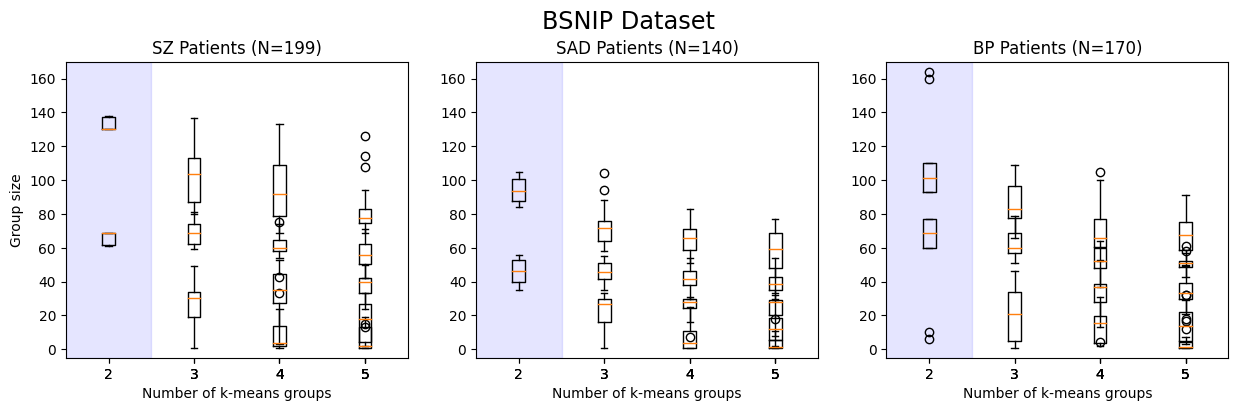

In [50]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3,figsize=(15,4))
fig.subplots_adjust(top=0.85)

ax[0].fill_between([1.5,2.5],[-5,-5],[170,170], color='blue',alpha=0.1)
ax[1].fill_between([1.5,2.5],[-5,-5],[170,170], color='blue',alpha=0.1)
ax[2].fill_between([1.5,2.5],[-5,-5],[170,170], color='blue',alpha=0.1)

ax[0].boxplot(sz2, positions=[2,2])
ax[0].boxplot(sz3, positions=[3,3,3])
ax[0].boxplot(sz4, positions=[4,4,4,4])
ax[0].boxplot(sz5, positions=[5,5,5,5,5])

ax[1].boxplot(sad2, positions=[2,2])
ax[1].boxplot(sad3, positions=[3,3,3])
ax[1].boxplot(sad4, positions=[4,4,4,4])
ax[1].boxplot(sad5, positions=[5,5,5,5,5])

ax[2].boxplot(bp2, positions=[2,2])
ax[2].boxplot(bp3, positions=[3,3,3])
ax[2].boxplot(bp4, positions=[4,4,4,4])
ax[2].boxplot(bp5, positions=[5,5,5,5,5])

ax[0].set_ylabel('Group size')

ax[0].set_xlabel('Number of k-means groups')
ax[1].set_xlabel('Number of k-means groups')
ax[2].set_xlabel('Number of k-means groups')

ax[0].set_title('SZ Patients (N=199)')
ax[1].set_title('SAD Patients (N=140)')
ax[2].set_title('BP Patients (N=170)')

ax[0].set_ylim([-5,170])
ax[1].set_ylim([-5,170])
ax[2].set_ylim([-5,170])

fig.suptitle('BSNIP Dataset', fontsize='xx-large')
fig.savefig('/home/anton/Documents/Tulane/Research/Work/Subtypes/FigureReproduceBSNIP.pdf')
fig.show()

In [24]:
import re

male2 = '''[[ 910 1126]
 [ 914 1122]
 [ 910 1126]
 [ 910 1126]
 [ 910 1126]
 [ 910 1126]
 [ 910 1126]
 [ 914 1122]
 [ 914 1122]
 [ 914 1122]
 [ 914 1122]
 [ 914 1122]
 [ 910 1126]
 [ 910 1126]
 [ 910 1126]
 [ 914 1122]
 [ 910 1126]
 [ 914 1122]
 [ 910 1126]
 [ 910 1126]]'''
male3 = '''[[456 772 808]
 [460 779 797]
 [454 774 808]
 [460 779 797]
 [454 774 808]
 [460 779 797]
 [458 771 807]
 [458 771 807]
 [460 779 797]
 [454 774 808]
 [454 774 808]
 [459 771 806]
 [459 773 804]
 [460 779 797]
 [454 774 808]
 [454 774 808]
 [454 774 808]
 [454 774 808]
 [458 770 808]
 [454 774 808]]'''
male4 = '''[[312 517 594 613]
 [367 542 552 575]
 [294 527 598 617]
 [358 542 561 575]
 [291 516 611 618]
 [292 532 596 616]
 [367 542 552 575]
 [  5 453 770 808]
 [344 538 571 583]
 [367 542 552 575]
 [332 555 558 591]
 [332 548 570 586]
 [367 542 552 575]
 [195 326 729 786]
 [291 516 611 618]
 [312 517 594 613]
 [301 556 575 604]
 [291 516 611 618]
 [296 525 598 617]
 [291 516 611 618]]'''
male5 = '''[[272 286 357 542 579]
 [279 321 349 534 553]
 [263 281 368 558 566]
 [  8 322 528 578 600]
 [303 325 378 505 525]
 [282 323 344 534 553]
 [  2 366 542 552 574]
 [289 299 355 534 559]
 [259 376 415 482 504]
 [  3 351 551 551 580]
 [272 283 347 553 581]
 [244 273 368 570 581]
 [337 345 375 455 524]
 [252 273 368 564 579]
 [252 273 368 564 579]
 [240 266 358 586 586]
 [282 324 344 534 552]
 [272 283 347 553 581]
 [278 319 437 496 506]
 [287 291 351 543 564]]'''

female2 = '''[[ 952 1355]
 [ 944 1363]
 [ 952 1355]
 [ 944 1363]
 [ 944 1363]
 [ 944 1363]
 [ 952 1355]
 [ 944 1363]
 [ 952 1355]
 [ 944 1363]
 [ 952 1355]
 [ 952 1355]
 [ 944 1363]
 [ 952 1355]
 [ 952 1355]
 [ 952 1355]
 [ 944 1363]
 [ 944 1363]
 [ 944 1363]
 [ 944 1363]]'''

female3 = '''[[ 466  824 1017]
 [ 402  835 1070]
 [ 466  824 1017]
 [ 466  824 1017]
 [ 466  824 1017]
 [ 453  823 1031]
 [ 466  824 1017]
 [ 435  828 1044]
 [ 466  824 1017]
 [ 466  824 1017]
 [ 466  824 1017]
 [ 402  835 1070]
 [ 466  824 1017]
 [ 466  824 1017]
 [ 466  824 1017]
 [ 466  824 1017]
 [ 402  835 1070]
 [ 466  824 1017]
 [ 402  835 1070]
 [ 463  827 1017]]'''
female4 = '''[[ 346  594  656  711]
 [ 316  618  663  710]
 [ 321  615  659  712]
 [ 345  608  650  704]
 [ 309  609  694  695]
 [ 309  609  694  695]
 [ 343  629  642  693]
 [ 346  594  656  711]
 [ 344  627  640  696]
 [ 343  614  643  707]
 [ 346  594  656  711]
 [ 315  619  663  710]
 [ 309  609  694  695]
 [ 309  609  694  695]
 [   1  466  823 1017]
 [ 346  594  656  711]
 [ 309  609  694  695]
 [ 309  609  694  695]
 [ 346  594  656  711]
 [ 309  609  694  695]]'''

female5 = ''' [[297 311 406 581 712]
 [290 319 419 576 703]
 [  8 309 607 691 692]
 [  1 346 594 655 711]
 [262 328 369 656 692]
 [281 328 419 576 703]
 [  4 309 609 692 693]
 [  1 311 606 694 695]
 [  3 315 619 657 713]
 [288 325 369 611 714]
 [262 321 377 656 691]
 [272 323 400 613 699]
 [262 321 377 656 691]
 [291 318 419 576 703]
 [283 317 368 640 699]
 [161 323 503 614 706]
 [212 387 482 566 660]
 [165 326 512 609 695]
 [213 350 507 575 662]
 [161 325 505 614 702]]'''

ea2 = '''[[ 741 1256]
 [ 740 1257]
 [ 754 1243]
 [ 754 1243]
 [ 740 1257]
 [ 740 1257]
 [ 740 1257]
 [ 754 1243]
 [ 754 1243]
 [ 754 1243]
 [ 740 1257]
 [ 740 1257]
 [ 740 1257]
 [ 754 1243]
 [ 740 1257]
 [ 750 1247]
 [ 740 1257]
 [ 754 1243]
 [ 754 1243]
 [ 740 1257]]'''
ea3 = '''[[   2  753 1242]
 [ 432  733  832]
 [ 442  740  815]
 [ 442  740  815]
 [ 435  744  818]
 [ 442  740  815]
 [ 442  740  815]
 [ 432  733  832]
 [   2  740 1255]
 [ 442  740  815]
 [ 442  740  815]
 [ 432  733  832]
 [ 432  733  832]
 [ 432  733  832]
 [ 432  733  832]
 [ 442  740  815]
 [ 432  733  832]
 [ 442  740  815]
 [ 432  733  832]
 [ 442  740  815]]'''

ea4 = '''[[253 476 621 647]
 [233 442 639 683]
 [253 476 621 647]
 [253 476 621 647]
 [253 476 621 647]
 [  1 432 733 831]
 [253 476 621 647]
 [233 442 639 683]
 [233 442 639 683]
 [253 476 621 647]
 [253 476 621 647]
 [253 476 621 647]
 [240 451 623 683]
 [236 439 639 683]
 [242 439 633 683]
 [253 476 621 647]
 [253 476 621 647]
 [233 442 639 683]
 [253 476 621 647]
 [243 445 626 683]]'''

ea5 = '''[[192 354 420 482 549]
 [213 250 285 590 659]
 [188 244 298 593 674]
 [221 344 433 467 532]
 [212 327 422 473 563]
 [218 349 422 479 529]
 [228 356 397 481 535]
 [210 241 278 608 660]
 [223 319 448 462 545]
 [224 360 397 481 535]
 [206 325 448 472 546]
 [223 319 429 471 555]
 [228 355 399 480 535]
 [188 239 312 585 673]
 [228 343 417 470 539]
 [218 244 274 593 668]
 [228 343 410 470 546]
 [227 357 397 481 535]
 [223 319 441 465 549]
 [188 238 312 586 673]]'''

aa2 = '''[[ 846 1006]
 [ 846 1006]
 [ 846 1006]
 [ 870  982]
 [ 870  982]
 [ 863  989]
 [ 846 1006]
 [ 846 1006]
 [ 846 1006]
 [ 846 1006]
 [ 863  989]
 [ 863  989]
 [ 870  982]
 [ 870  982]
 [ 870  982]
 [ 846 1006]
 [ 846 1006]
 [ 846 1006]
 [ 846 1006]
 [ 863  989]]'''
aa3 ='''[[ 434  668  750]
 [ 386  692  774]
 [ 407  677  768]
 [ 386  692  774]
 [ 422  671  759]
 [ 434  668  750]
 [   2  842 1008]
 [ 425  665  762]
 [ 386  692  774]
 [ 434  668  750]
 [ 386  692  774]
 [ 386  692  774]
 [ 434  668  750]
 [ 386  692  774]
 [ 386  692  774]
 [ 434  668  750]
 [ 434  668  750]
 [ 427  668  757]
 [ 434  668  750]
 [ 434  668  750]]'''
aa4 = '''[[313 354 474 711]
 [333 388 532 599]
 [  3 402 681 766]
 [209 350 580 713]
 [313 353 476 710]
 [  2 423 667 760]
 [265 354 546 687]
 [329 389 532 602]
 [256 352 534 710]
 [316 450 525 561]
 [313 354 474 711]
 [282 495 536 539]
 [238 495 549 570]
 [271 347 525 709]
 [267 352 546 687]
 [216 370 578 688]
 [  1 434 667 750]
 [240 516 542 554]
 [313 354 474 711]
 [219 389 587 657]]'''
aa5 = '''[[238 241 360 504 509]
 [216 247 345 520 524]
 [265 316 331 400 540]
 [232 261 379 467 513]
 [253 268 375 405 551]
 [250 293 326 463 520]
 [  1 312 352 476 711]
 [238 242 361 503 508]
 [241 243 357 503 508]
 [272 337 353 373 517]
 [268 325 337 390 532]
 [195 234 365 401 657]
 [216 242 347 520 527]
 [216 247 345 520 524]
 [215 236 354 519 528]
 [217 242 347 517 529]
 [  3 333 389 530 597]
 [221 242 349 515 525]
 [253 328 350 389 532]
 [237 249 347 502 517]]'''


def str2arr(inp):
    out = []
    for line in inp.split('\n'):
        m = list(filter(None, re.split('[[\]\s]+', line)))
        m = [int(val) for val in m]
        out.append(m)
    return np.array(out)

male2 = str2arr(male2)
male3 = str2arr(male3)
male4 = str2arr(male4)
male5 = str2arr(male5)

female2 = str2arr(female2)
female3 = str2arr(female3)
female4 = str2arr(female4)
female5 = str2arr(female5)

ea2 = str2arr(ea2)
ea3 = str2arr(ea3)
ea4 = str2arr(ea4)
ea5 = str2arr(ea5)

aa2 = str2arr(aa2)
aa3 = str2arr(aa3)
aa4 = str2arr(aa4)
aa5 = str2arr(aa5)

/tmp/ipykernel_3785377/1688271239.py:335: FutureWarning: Possible nested set at position 1
  m = list(filter(None, re.split('[[\]\s]+', line)))


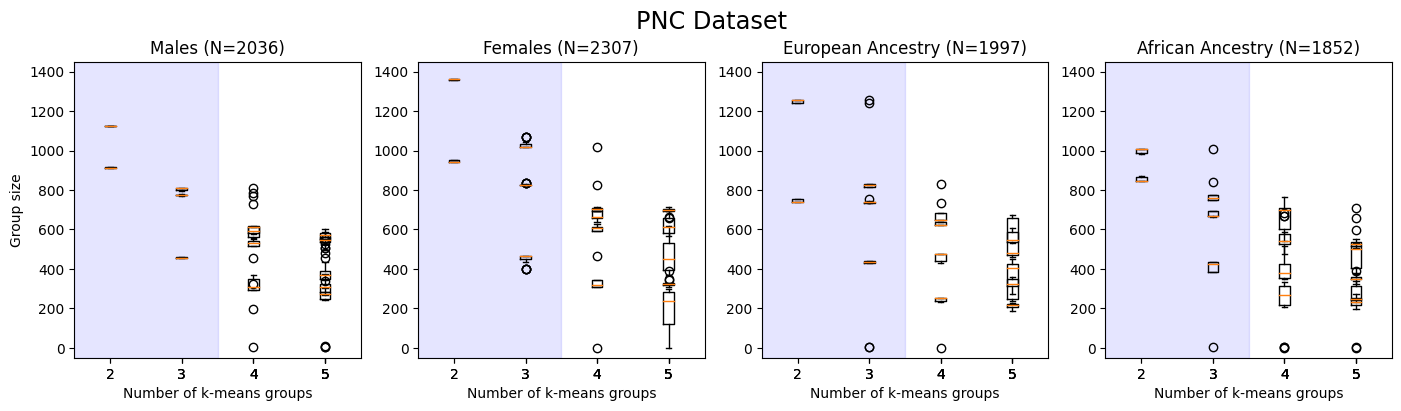

In [51]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,4,figsize=(17,4))
fig.subplots_adjust(top=0.85)

ax[0].fill_between([1.5,3.5],[-50,-50],[1450,1450], color='blue',alpha=0.1)
ax[1].fill_between([1.5,3.5],[-50,-50],[1450,1450], color='blue',alpha=0.1)
ax[2].fill_between([1.5,3.5],[-50,-50],[1450,1450], color='blue',alpha=0.1)
ax[3].fill_between([1.5,3.5],[-50,-50],[1450,1450], color='blue',alpha=0.1)

ax[0].boxplot(male2, positions=[2,2])
ax[0].boxplot(male3, positions=[3,3,3])
ax[0].boxplot(male4, positions=[4,4,4,4])
ax[0].boxplot(male5, positions=[5,5,5,5,5])

ax[1].boxplot(female2, positions=[2,2])
ax[1].boxplot(female3, positions=[3,3,3])
ax[1].boxplot(female4, positions=[4,4,4,4])
ax[1].boxplot(female5, positions=[5,5,5,5,5])

ax[2].boxplot(ea2, positions=[2,2])
ax[2].boxplot(ea3, positions=[3,3,3])
ax[2].boxplot(ea4, positions=[4,4,4,4])
ax[2].boxplot(ea5, positions=[5,5,5,5,5])

ax[3].boxplot(aa2, positions=[2,2])
ax[3].boxplot(aa3, positions=[3,3,3])
ax[3].boxplot(aa4, positions=[4,4,4,4])
ax[3].boxplot(aa5, positions=[5,5,5,5,5])

ax[0].set_ylabel('Group size')

ax[0].set_xlabel('Number of k-means groups')
ax[1].set_xlabel('Number of k-means groups')
ax[2].set_xlabel('Number of k-means groups')
ax[3].set_xlabel('Number of k-means groups')

ax[0].set_title('Males (N=2036)')
ax[1].set_title('Females (N=2307)')
ax[2].set_title('European Ancestry (N=1997)')
ax[3].set_title('African Ancestry (N=1852)')

ax[0].set_ylim([-50,1450])
ax[1].set_ylim([-50,1450])
ax[2].set_ylim([-50,1450])
ax[3].set_ylim([-50,1450])

fig.suptitle('PNC Dataset', fontsize='xx-large')
fig.savefig('/home/anton/Documents/Tulane/Research/Work/Subtypes/FigureReproducePNC.pdf')
fig.show()